# Total 106-121

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from catboost import Pool, CatBoostRegressor, cv
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz106_121.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_106to121']
X0 = df.loc[:, ~df.columns.isin(['std_inz_106to121', 'eastwest'])]
print("Number of features: ", len(X0.columns))

Number of features:  163


# Feature Correlation

In [4]:
a=["G_latitude","INC_Bruttow","PRE_v652","SSE_AnteilErh","SSE_AnteilFre","SSE_AnteilFre","SSE_Freiflaec","SSE_Freiflaec","SSE_Laendlich","SSE_Laendlich","SSE_Siedlungs","SSE_Siedlungs","SSE_Siedlungs","SSE_v817","SSE_v817","SSE_v817","SSE_v817","SSE_v817","SSE_v967","SSE_v967","SSE_v967","SSE_v967","SSE_weighted_","UE_AntreBesc","UE_Arbquote2","UE_Arbquote2","UE_Arbquote2","UE_ArbquoteJ","UE_BesePrima","UE_v323","UE_v323","UE_v324","UE_v341","HC_Vorzeitig","D_v599","UE_AnteBesch","D_v424","UE_v231","D_Abhaen","HC_I_t","HC_II_t","HC_I_t","HC_Pflegehe","IS_mitarbeitsweg30","IS_mitarbeitsweg15","IS_v1071","IS_v1071","IS_v1073","PO_Hausha","PRE_v739","IS_v1069","IS_v1071","SSE_AnteilWas","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_v817","SSE_v967","IS_v1070","SSE_Waldflaec","IS_v1071","SSE_Freiflaec","IS_v1069","SSE_AnteilFre","IS_v1071","IS_v1069","IS_v1071","SSE_Siedlungs","SSE_AnteilErh","SSE_AnteilFre","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_v817","SSE_grand_sd_","INC_Schuldn","UE_ArbquoteJ","IS_auspen","IS_endlersaldo2017","HC_aerztever","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_Einwohner","SSE_v817","SSE_v967","UE_v342","PRE_v727","PRE_v739","PRE_v733","UE_v381","UE_v341","UE_v323","UE_v261","UE_v381","UE_v323","UE_v341","UE_v381","UE_v341","UE_v381"]
print(set(a),"\n\n",len(set(a)),"features droped")

{'SSE_AnteilErh', 'G_latitude', 'INC_Schuldn', 'PRE_v652', 'D_v599', 'HC_aerztever', 'PRE_v727', 'UE_v381', 'SSE_Waldflaec', 'IS_auspen', 'SSE_weighted_', 'UE_v341', 'UE_v342', 'D_v424', 'SSE_Einwohner', 'IS_v1069', 'D_Abhaen', 'SSE_grand_sd_', 'UE_ArbquoteJ', 'UE_AntreBesc', 'IS_mitarbeitsweg30', 'UE_v324', 'HC_I_t', 'UE_BesePrima', 'IS_v1070', 'SSE_Laendlich', 'IS_endlersaldo2017', 'HC_Vorzeitig', 'PO_Hausha', 'HC_II_t', 'SSE_AnteilWas', 'PRE_v733', 'HC_Pflegehe', 'SSE_AnteilFre', 'INC_Bruttow', 'UE_Arbquote2', 'UE_AnteBesch', 'SSE_v817', 'IS_mitarbeitsweg15', 'SSE_Freiflaec', 'SSE_v967', 'UE_v261', 'UE_v323', 'IS_v1073', 'PRE_v739', 'SSE_Siedlungs', 'UE_v231', 'IS_v1071'} 

 48 features droped


In [5]:
X = X0.drop(columns=['D_v599', 'HC_Vorzeitig', 'UE_Arbquote2', 'HC_aerztever', 'IS_endlersaldo2017', 'UE_AntreBesc', 'SSE_Waldflaec', 'IS_auspen', 'SSE_Siedlungs', 'UE_AnteBesch', 'D_v424', 'UE_v323', 'UE_ArbquoteJ', 'UE_BesePrima', 'HC_Pflegehe', 'INC_Schuldn', 'HC_II_t', 'IS_mitarbeitsweg15', 'SSE_AnteilErh', 'HC_I_t', 'PRE_v727', 'G_latitude', 'UE_v324', 'SSE_grand_sd_', 'PRE_v733', 'IS_mitarbeitsweg30', 'SSE_Laendlich', 'SSE_AnteilFre', 'UE_v261', 'PO_Hausha', 'UE_v341', 'INC_Bruttow', 'SSE_Einwohner', 'SSE_Freiflaec', 'SSE_v817', 'IS_v1071', 'SSE_AnteilWas', 'PRE_v652', 'SSE_weighted_', 'UE_v381', 'SSE_v967', 'IS_v1069', 'PRE_v739', 'UE_v342', 'IS_v1073', 'D_Abhaen', 'IS_v1070', 'UE_v231'])
print("New number of features: ", len(X.columns))

New number of features:  115


# First CatBoost Model with 162 features

In [6]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9991455411650825


In [7]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.9986896655706606


# SHAP VAlues

In [8]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


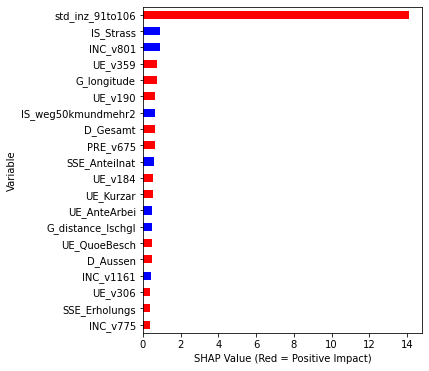

In [9]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# Second CatBoost model with 20 most important features

In [10]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [11]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9960756845373661


In [12]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  2.1402619929638647


# Compare top 10 features of both Models

In [13]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_91to106', 'IS_Strass', 'INC_v801', 'UE_v359', 'G_longitude', 'UE_v190', 'IS_weg50kmundmehr2', 'D_Gesamt', 'PRE_v675', 'SSE_Anteilnat'] 

 10 most important features from model with top20 features: 
 ['std_inz_91to106', 'G_longitude', 'IS_Strass', 'UE_v190', 'UE_QuoeBesch', 'IS_weg50kmundmehr2', 'PRE_v675', 'D_Aussen', 'UE_AnteArbei', 'UE_Kurzar']


In [14]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_91to106
IS_Strass
G_longitude
UE_v190
IS_weg50kmundmehr2
PRE_v675


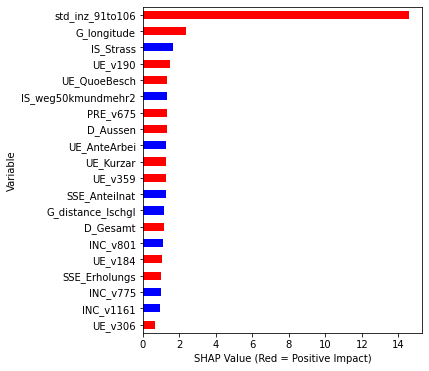

In [15]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

# Hold out validation of the second model

In [16]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [17]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9977150457326148
Mean R2 of linReg_modesl with top20 features:  0.5855007556411198
Mean RMSE of CatBoost_models on test sets with top20 features:  21.497772207069207
Mean R2 of CatBoost_models on test sets with top20 features: 0.5571953775631167


# descriptives of top20 features

In [18]:
X[top20feature].describe()

,std_inz_91to106,IS_Strass,INC_v801,UE_v359,G_longitude,UE_v190,IS_weg50kmundmehr2,D_Gesamt,PRE_v675,SSE_Anteilnat,UE_v184,UE_Kurzar,UE_AnteArbei,G_distance_Ischgl,UE_QuoeBesch,D_Aussen,INC_v1161,UE_v306,SSE_Erholungs,INC_v775
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,79.007408,491.092926,2846.079834,68.926407,9.866996,11.710718,11.484290,5.103242,16.566586,5.101742,2.814465,0.752618,22.971313,431.346405,49.557602,4.806734,35.613968,-6.157606,70.509460,14.988533
std,72.684265,87.669609,926.153870,11.196052,2.026269,3.008996,3.481254,4.276379,5.035090,3.710643,3.325890,1.440882,4.190943,187.236847,5.944390,6.630641,15.809457,22.530605,56.734707,4.460500
min,3.607589,275.799988,28.000000,27.500000,6.083333,4.600000,4.900000,-14.000000,6.900000,0.900000,-7.200000,0.000000,14.500000,56.052784,29.600000,-13.900000,16.000000,-69.900002,14.000000,1.000000
25%,34.004898,431.399994,2706.000000,62.099998,8.216666,10.600000,9.000000,2.500000,13.000000,2.700000,0.500000,0.000000,19.500000,291.752441,45.700001,1.500000,26.799999,-14.200000,39.700001,12.600000
50%,56.944515,476.399994,3052.000000,70.000000,9.766666,12.400000,10.800000,5.100000,16.100000,4.300000,3.100000,0.300000,22.700001,420.680756,49.900002,3.700000,31.400000,-7.700000,52.799999,15.000000
75%,107.506599,545.000000,3329.000000,76.699997,11.416667,13.600000,13.300000,7.500000,19.700001,6.300000,5.100000,0.900000,25.900000,569.178772,53.599998,6.000000,38.799999,-0.800000,76.699997,17.700001
max,721.384521,803.599976,4855.000000,95.099998,14.983334,20.200001,24.200001,21.299999,38.000000,34.000000,12.400000,19.600000,34.700001,866.911194,66.400002,65.900002,178.800003,329.000000,384.600006,35.599998


In [19]:
pd.DataFrame(Y).describe()

,std_inz_106to121
count,401.000000
mean,35.316822
std,34.207966
min,0.000000
25%,11.892441
50%,25.522655
75%,47.308884
max,223.532379


In [20]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives4.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 4')